In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [41]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 10)*1.e9
input_params = [A, alpha, beta, gamma]
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

# define the input model

In [42]:
in_model = ff.model(ells, freqs, input_params)

# define the 2d data we're going to try to fit

In [43]:
#define some data with a constant beta at the higher nside and try to fit the 0x0 moment.

In [52]:
high_maps = ff.map_full_const_beta(np.arange(768),freqs,[A, alpha, beta])
print(high_maps.shape)

(10, 786432)


In [45]:
mom0x0 = ff.auto0x0(ells, freqs, [A, alpha, beta])

In [54]:
print(hp.anafast(high_maps[0])[:384].shape)

(384,)


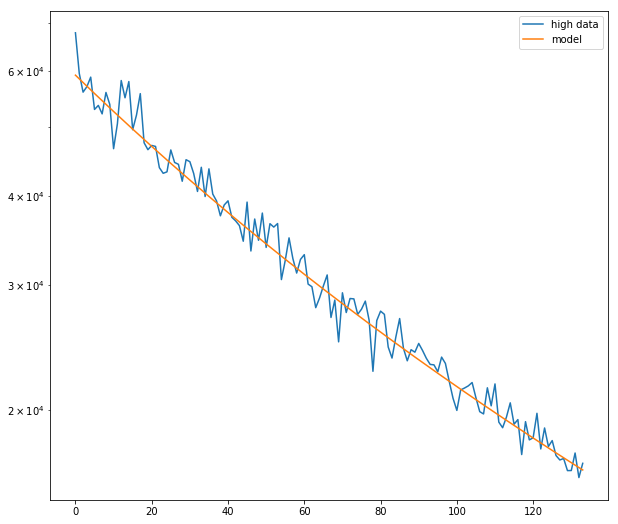

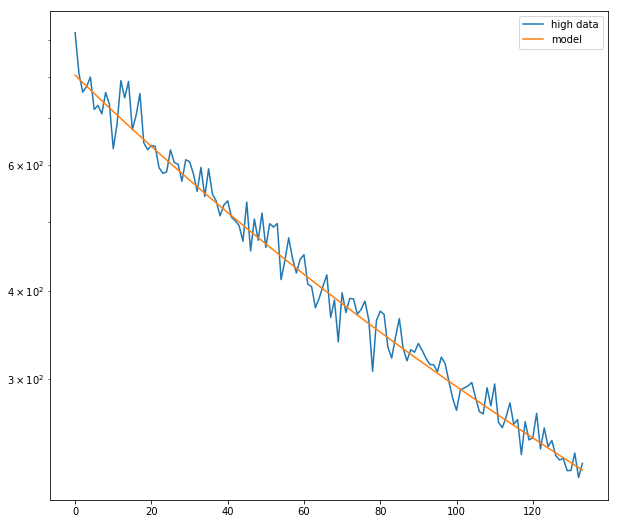

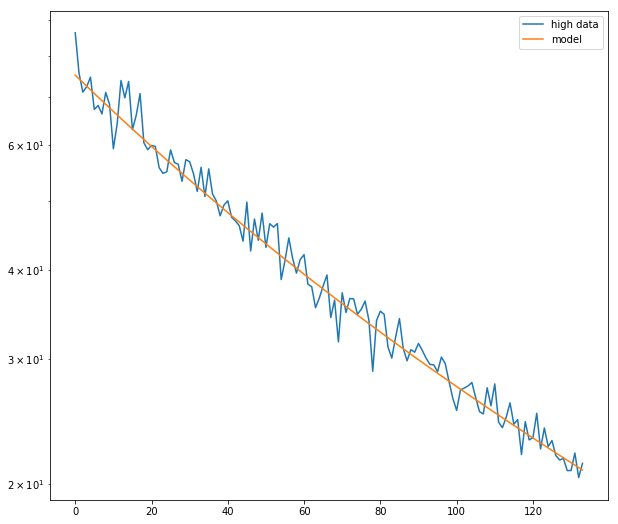

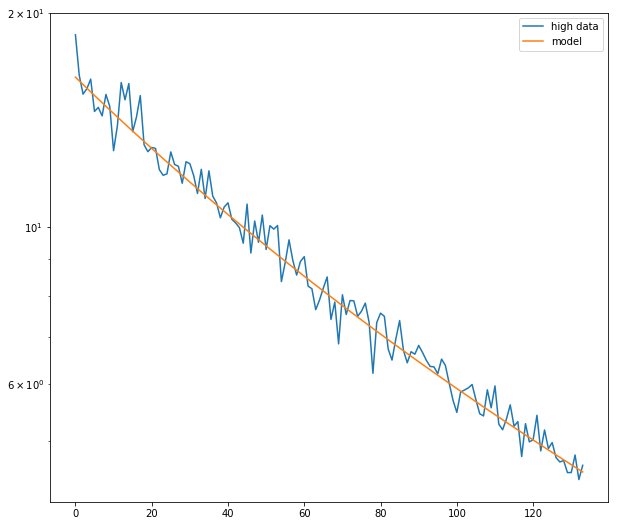

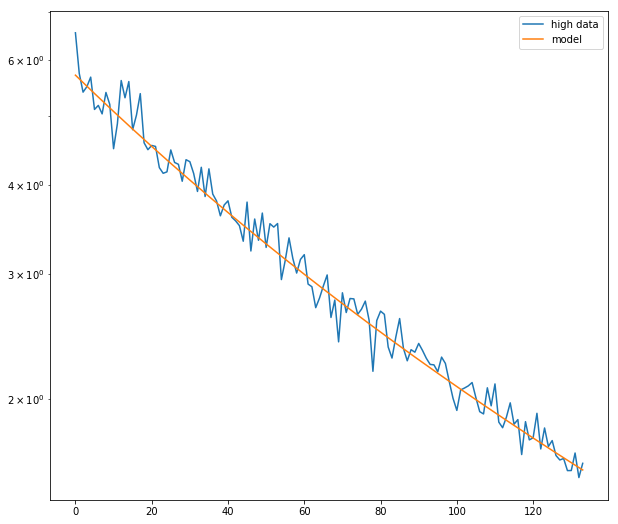

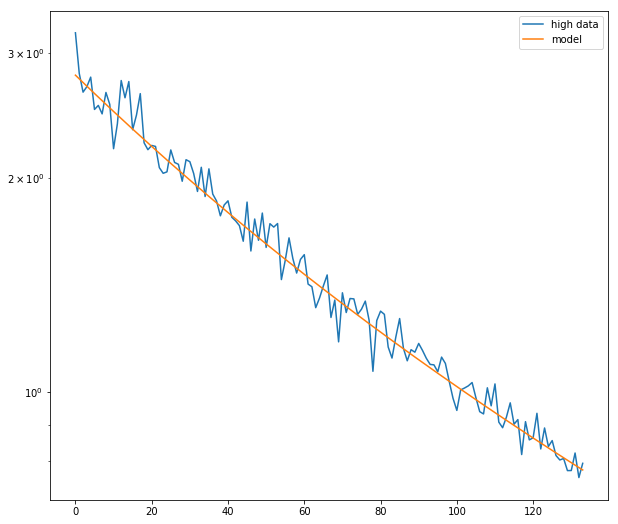

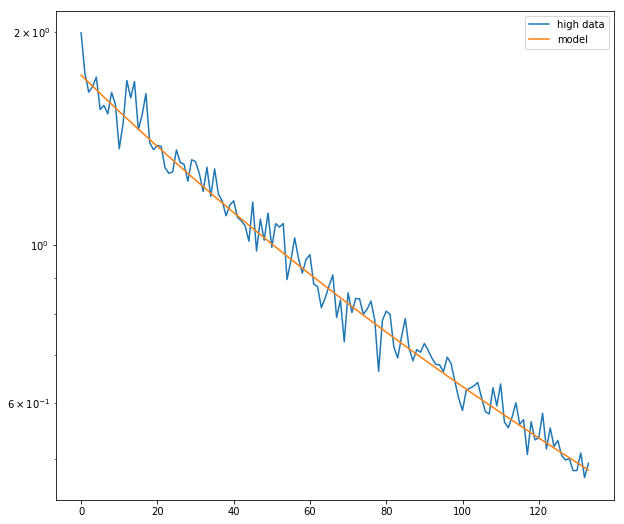

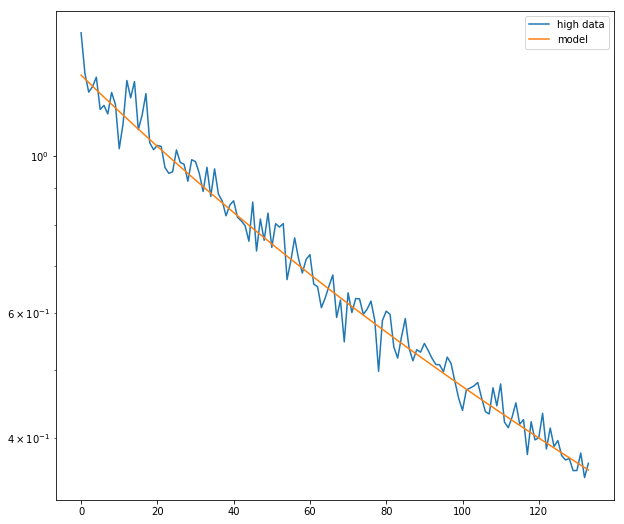

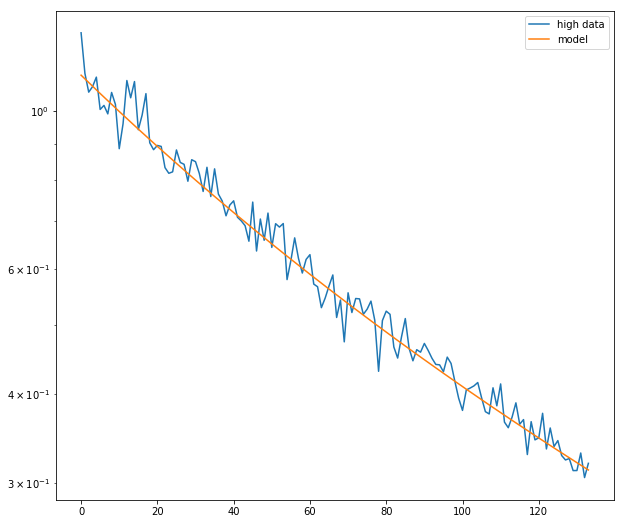

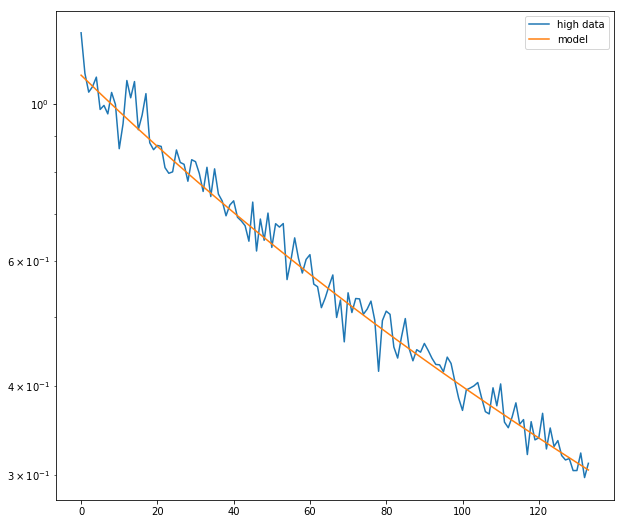

In [51]:
for i in range(len(freqs)):
    figure(figsize=(10,9))
    semilogy(hp.anafast(high_maps[i])[250:384], label='high data')
    semilogy(mom0x0[i][250:], label='model')
    legend()

In [60]:
def chi2(params, ells, freqs, data):
    chi2=0
    A, alpha, beta = params
    model = ff.auto0x0(ells, freqs, params)
    
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    
    #don't count the first 30 ell in the objective function.
    chi2 = (data[:,30:] - model[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [61]:
ps_data_const = np.zeros((len(freqs),len(ells)))
print(ps_data_const.shape)
for i in range(len(freqs)):
    ps_data_const[i] = hp.anafast(high_maps[i])[:384]

(10, 384)


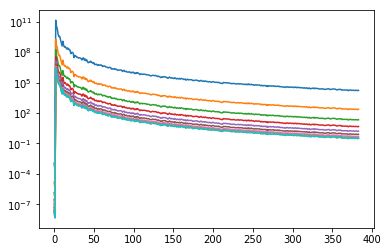

In [58]:
semilogy(ps_data_const.T);

In [62]:
start=time.time()
result0 = minimize(chi2, [1e3, -1,-1], args=(ells, freqs, ps_data_const), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None)))
print(time.time()-start)
print(result0)

0.0973970890045166
      fun: 3396.992559950986
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.09494702e-05, 5.42058842e-02, 4.92946128e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 37
   status: 0
  success: True
        x: array([1739.14838578,   -3.01891906,   -3.20000003])


In [67]:
x0 = result0.x
fit0 = ff.auto0x0(ells, freqs, x0)

In [65]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

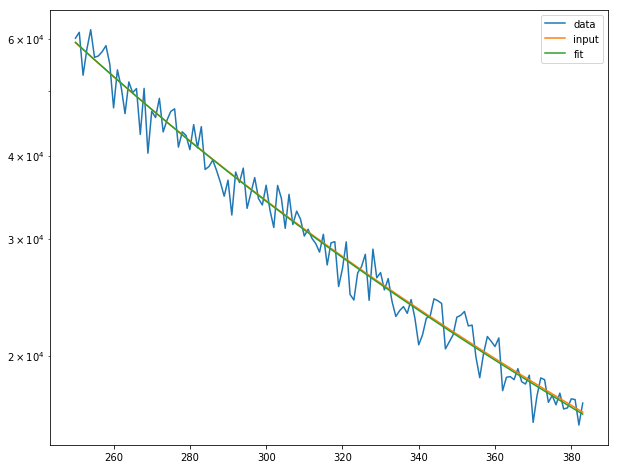

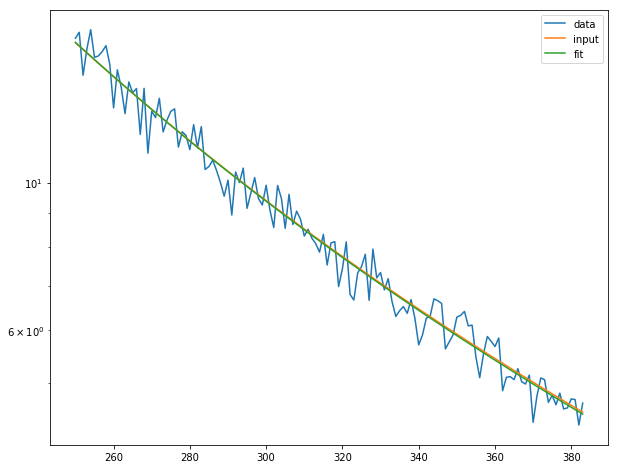

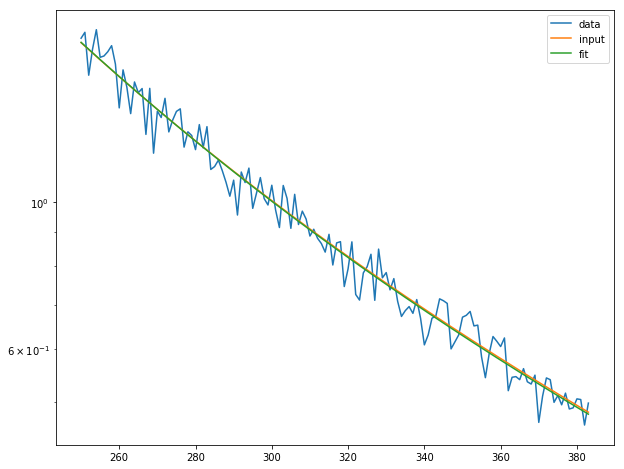

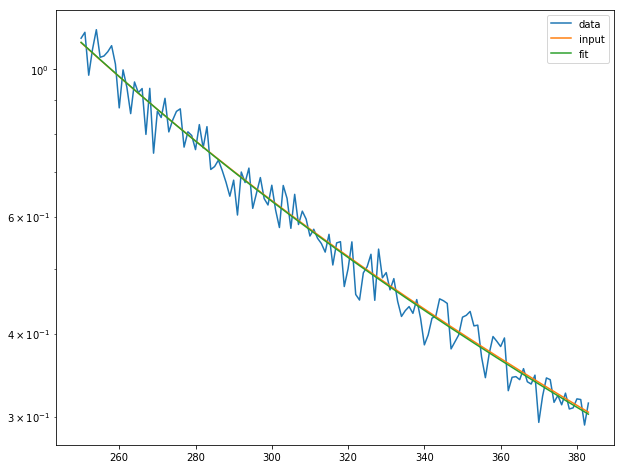

In [74]:
for i in range(len(freqs)):
    if i%3 == 0:
        figure()
        semilogy(ells[250:], ps_data_const[i][250:], label='data')
        semilogy(ells[250:], mom0x0[i][250:], label='input')
        semilogy(ells[250:], fit0[i][250:], label='fit')
        legend()